In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import statsmodels.api as sm
import itertools
import numpy as np

from pyspark.sql import SparkSession 
from pyspark.sql import SQLContext 
from pyspark import SparkContext 
from pyspark.sql.types import * 
from pyspark.sql.functions import * 
from statsmodels.tsa.stattools import adfuller 
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# Initialising Spark Session
spark = SparkSession\
    .builder\
    .appName("crime_analysis")\
    .getOrCreate()

# Validating Spark Session
spark
 

SparkSession - hive 
 
 
 SparkContext 

 Spark UI 

 
 Version 
 v3.3.2 
 Master 
 local[8] 
 AppName 
 Databricks Shell

In [0]:
# Defining the schema for crime data
crime_schema = StructType(
    [StructField("Crime ID", StringType(), False),
     StructField("Month", StringType(), False),
     StructField("Reported by", StringType(), False),
     StructField("Falls within", StringType(), False),
     StructField("Longitude", FloatType(), False),
     StructField("Latitude", FloatType(), False),
     StructField("Location", StringType(), False),
     StructField("LSOA code", StringType(), False),
     StructField("LSOA name", StringType(), False),
     StructField("Crime type", StringType(), False),
     StructField("Last outcome category", StringType(), False),
     StructField("Context", StringType(), False)
     ])

In [0]:
# Loading the crime data and renaming columns
crime = spark.read.load("/FileStore/tables/sample_10.csv", 
format="csv", sep=",", schema=crime_schema, header="true")\
.withColumnRenamed("Crime ID", "CrimeID")\
.withColumnRenamed("Reported by", "ReportedBy")\
.withColumnRenamed("Falls within", "FallsWithin")\
.withColumnRenamed("LSOA code", "LSOAcode")\
.withColumnRenamed("LSOA name", "LSOAname")\
.withColumnRenamed("Crime type", "CrimeType")\
.withColumnRenamed("Last outcome category", "Outcome")
crime.show(5)
crime.printSchema()

+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+--------------------+--------------------+-------+
|             CrimeID|  Month|          ReportedBy|         FallsWithin|Longitude| Latitude|            Location| LSOAcode|           LSOAname|           CrimeType|             Outcome|Context|
+--------------------+-------+--------------------+--------------------+---------+---------+--------------------+---------+-------------------+--------------------+--------------------+-------+
|                null|2011-08|Lancashire Consta...|Lancashire Consta...| -3.04257|53.818638|On or near Church...|E01012735|     Blackpool 010C|         Other crime|                null|   null|
|                null|2015-01|Norfolk Constabulary|Norfolk Constabulary|  1.68407| 52.69677|On or near Stable...|E01026605|Great Yarmouth 001A|Anti-social behav...|                null|   null|
|d7ac3f3005101a7c5...|2011-12|

In [0]:
# Making the tables for SQL string queries 
crime.registerTempTable("crime_table")


In [0]:
# Checking for missing values in the CrimeType column
missing_crime_type = spark.sql("""
SELECT COUNT(*) AS missing_crimetype
FROM crime_table
WHERE CrimeType IS NULL
""")
missing_crime_type.show()

# Checking for missing values in the LSOAcode column
missing_lsoa_code = spark.sql("""
SELECT COUNT(*) AS missing_lsoa
FROM crime_table
WHERE LSOAcode IS NULL
""")
missing_lsoa_code.show()


+-----------------+
|missing_crimetype|
+-----------------+
|                0|
+-----------------+

+------------+
|missing_lsoa|
+------------+
|      252709|
+------------+



In [0]:
# Checking for duplicates crime data
duplicate_crime = spark.sql("""
    SELECT *, COUNT(*) AS count
    FROM crime_table
    GROUP BY CrimeID, Month, ReportedBy, FallsWithin, Longitude, Latitude, Location, LSOAcode, LSOAname, CrimeType, Outcome, Context
    HAVING count > 1
""")
duplicate_crime.show()


+-------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+-------+-------+-----+
|CrimeID|  Month|          ReportedBy|         FallsWithin|Longitude| Latitude|            Location| LSOAcode|            LSOAname|           CrimeType|Outcome|Context|count|
+-------+-------+--------------------+--------------------+---------+---------+--------------------+---------+--------------------+--------------------+-------+-------+-----+
|   null|2020-09|Metropolitan Poli...|Metropolitan Poli...|-0.382436| 51.50697|On or near Lewis ...|E01001362|         Ealing 026C|Anti-social behav...|   null|   null|    2|
|   null|2012-12|Metropolitan Poli...|Metropolitan Poli...|-0.224438|51.503513|On or near Theatr...|E01001941|Hammersmith and F...|Anti-social behav...|   null|   null|    3|
|   null|2016-09|Greater Mancheste...|Greater Mancheste...|-2.235266| 53.48848|On or near Naples...|E01033664|     Manchester

In [0]:
# Dropping duplicates
crime_cleaned = crime.dropDuplicates()

# Making the tables for SQL string queries 
crime_cleaned.registerTempTable("crime_cleaned")

Is the number of serious crime cases increasing in the UK?

In [0]:
# Creating a dataframe
serious_crime = spark.sql("""
    SELECT Month, count(CrimeType) as CrimeNumbers 
    FROM crime_cleaned
    WHERE CrimeType IN ('Violent crime', 'Violence and sexual offences', 'Robbery', 'Possession of weapons', 'Criminal damage and arson', 'Burglary') 
    GROUP BY Month
    ORDER BY Month
""")

# Converting to a Pandas dataframe
serious_crime_pd = serious_crime.toPandas()

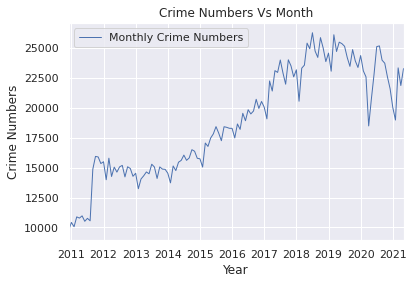

In [0]:
# Converting to date type and setting index
serious_crime_pd.Month = serious_crime_pd.Month.astype('datetime64[ns]')
serious_crime_date = serious_crime_pd.set_index(pd.to_datetime(serious_crime_pd.Month))

serious_crime_date.index

# Plotting
serious_crime_date.plot(y='CrimeNumbers', x='Month',linestyle='-', linewidth=1,\
        subplots=False,
        label='Monthly Crime Numbers',
        title='Crime Numbers Vs Month')
plt.ylabel('Crime Numbers')
plt.xlabel('Year')
plt.show()

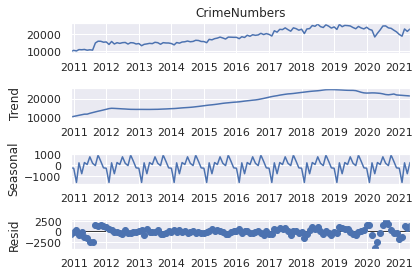

In [0]:
# Performing the time series decomposition 
decomposition = sm.tsa.seasonal_decompose(serious_crime_date['CrimeNumbers'], model='additive',extrapolate_trend='freq')
fig = decomposition.plot()
plt.show()

Are there any crime types that are associated?

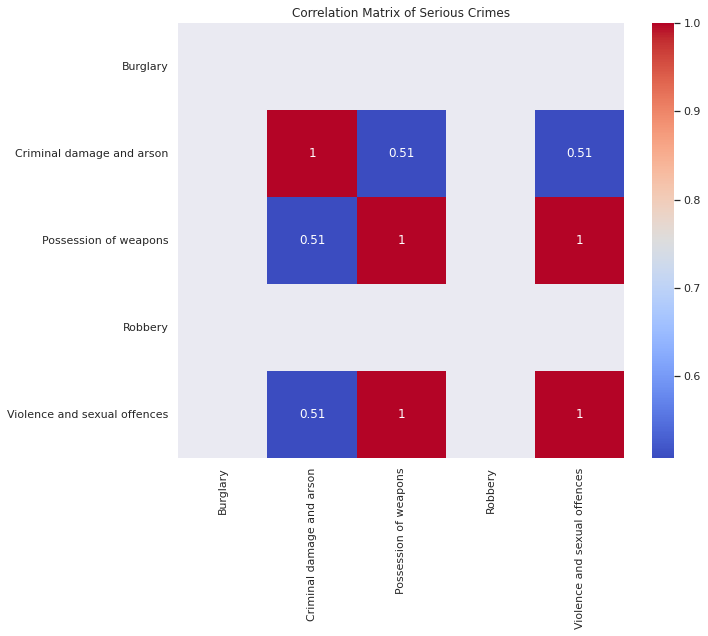

In [0]:
# Pivotting data to have CrimeType as columns
crime_pivot = serious_crime_type.groupBy("Month", "CrimeType").count().groupBy("Month").pivot("CrimeType").sum("Count").fillna(0)

# Converting to Pandas
crime_pivot_pd = crime_pivot.toPandas()

# Creating correlation matrix
corr_matrix = crime_pivot_pd.corr()

# Plotting
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Serious Crimes')
plt.show()


Any anomaly detected in patterns?

In [0]:
# Creating a dataframe including crime types
serious_crime_type = spark.sql("""
SELECT
    Month, 
    CrimeType, 
    COUNT(*) as Count
FROM crime_cleaned
WHERE CrimeType IN ('Violence and sexual offences', 'Robbery', 
                    'Possession of weapons', 'Criminal damage and arson', 'Burglary')
GROUP BY Month, CrimeType
ORDER BY Month
""")
serious_crime_type.show()

+-------+---------+-----+
|  Month|CrimeType|Count|
+-------+---------+-----+
|2010-12| Burglary| 3738|
|2010-12|  Robbery|  586|
|2011-01| Burglary| 4228|
|2011-01|  Robbery|  655|
|2011-02| Burglary| 4080|
|2011-02|  Robbery|  652|
|2011-03| Burglary| 4323|
|2011-03|  Robbery|  649|
|2011-04| Burglary| 3962|
|2011-04|  Robbery|  643|
|2011-05|  Robbery|  663|
|2011-05| Burglary| 4261|
|2011-06| Burglary| 3952|
|2011-06|  Robbery|  630|
|2011-07| Burglary| 3982|
|2011-07|  Robbery|  620|
|2011-08|  Robbery|  582|
|2011-08| Burglary| 4117|
|2011-09| Burglary| 4048|
|2011-09|  Robbery|  467|
+-------+---------+-----+
only showing top 20 rows



In [0]:
# Converting to a Pandas dataframe
serious_type_pd = serious_crime_type.toPandas()

# Converting to date type and setting index
serious_type_pd.Month = serious_type_pd.Month.astype('datetime64[ns]')
serious_type_date = serious_type_pd.set_index(pd.to_datetime(serious_type_pd.Month))

serious_type_date.index

Out[39]: DatetimeIndex(['2010-12-01', '2010-12-01', '2011-01-01', '2011-01-01',
               '2011-02-01', '2011-02-01', '2011-03-01', '2011-03-01',
               '2011-04-01', '2011-04-01',
               ...
               '2021-04-01', '2021-04-01', '2021-04-01', '2021-04-01',
               '2021-04-01', '2021-05-01', '2021-05-01', '2021-05-01',
               '2021-05-01', '2021-05-01'],
              dtype='datetime64[ns]', name='Month', length=563, freq=None)

In [0]:
# Reshaping the dataframe to have a column for each type
date_pivot = serious_type_date.pivot_table(values='Count', index=serious_type_date.index, columns='CrimeType', fill_value=0)

# Normalising the data)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(date_pivot)

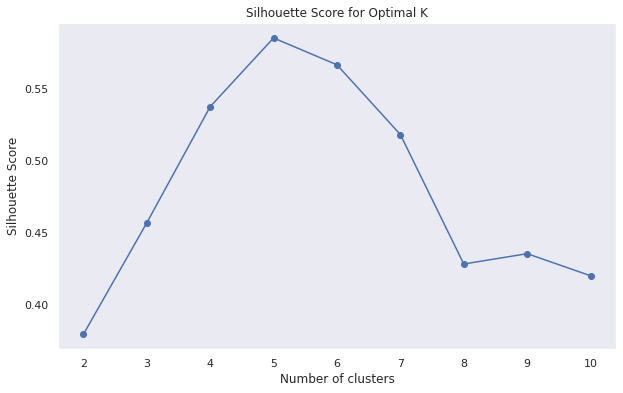

In [0]:
# Defining the range of clusters to test
range_n_clusters = range(1, 11)  # Testing for 1 to 10 clusters

# Calculating the silhouette values
silhouette_scores = []  
for n_clusters in range_n_clusters[1:]:  
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(scaled_data)
    score = silhouette_score(scaled_data, kmeans.labels_)
    silhouette_scores.append(score)

# Plotting the Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters[1:], silhouette_scores, marker='o')
plt.title('Silhouette Score for Optimal K')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.xticks(range_n_clusters[1:])
plt.grid()
plt.show()


Detected Anomalies:
CrimeType   Burglary  Criminal damage and arson  Possession of weapons  \
Month                                                                    
2020-03-01      2592                       4098                    344   
2020-04-01      1896                       3218                    290   
2020-08-01      2199                       4508                    406   

CrimeType   Robbery  Violence and sexual offences  Cluster  \
Month                                                        
2020-03-01      586                         14972        4   
2020-04-01      296                         12795        4   
2020-08-01      620                         17453        4   

CrimeType   Distance from Center  Anomaly  
Month                                      
2020-03-01            1.41836580     True  
2020-04-01            1.66106229     True  
2020-08-01            1.60697849     True  


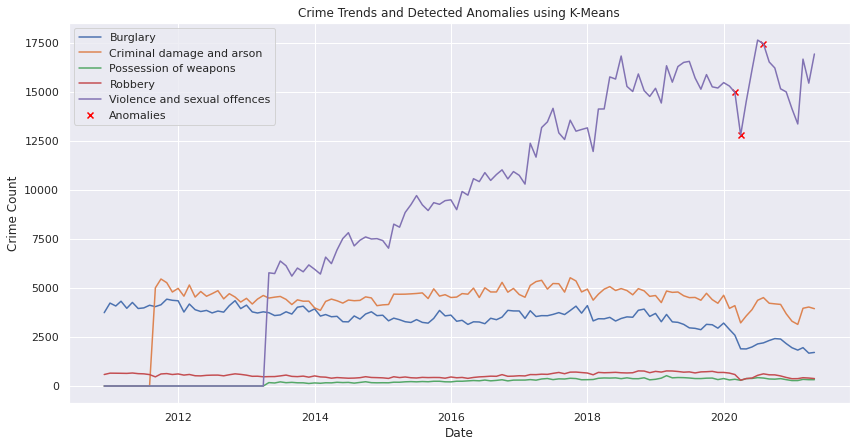

In [0]:
# Applying K-Means clustering
n_clusters = 5  
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
date_pivot['Cluster'] = kmeans.fit_predict(scaled_data)

# Calculating the distance from the cluster center to identify anomalies
date_pivot['Distance from Center'] = np.linalg.norm(scaled_data - kmeans.cluster_centers_[date_pivot['Cluster']], axis=1)

# Defining threshold for anomaly detection (mean + 2*std)
threshold = date_pivot['Distance from Center'].mean() + 2 * date_pivot['Distance from Center'].std()
date_pivot['Anomaly'] = date_pivot['Distance from Center'] > threshold

anomalies = date_pivot[date_pivot['Anomaly']]
print("Detected Anomalies:")
print(anomalies)

# Plotting
plt.figure(figsize=(14, 7))
for crime_type in date_pivot.columns[:-3]:
    plt.plot(date_pivot.index, date_pivot[crime_type], label=crime_type)

# Highlighting anomalies
plt.scatter(anomalies.index, anomalies[crime_type], color='red', label='Anomalies', marker='x')

plt.title('Crime Trends and Detected Anomalies using K-Means')
plt.xlabel('Date')
plt.ylabel('Crime Count')
plt.legend()
plt.show()



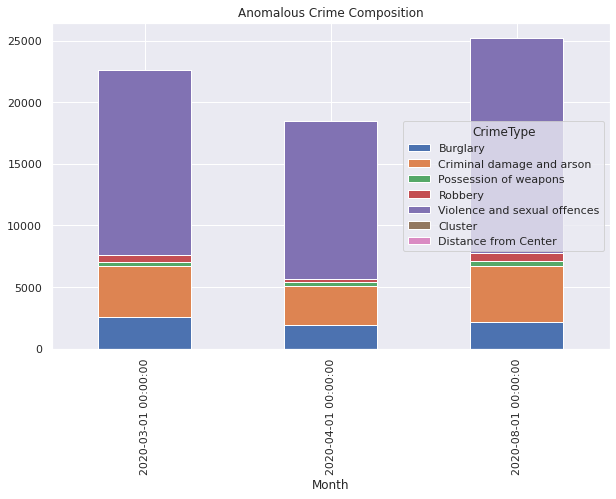

In [0]:
# Visualising the composition
anomalies.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Anomalous Crime Composition')
plt.show()


How would crime trends have been if there had been no COVID-19?

In [0]:
# Plotting for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    plt.clf()
   
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()
    plt.show()

<Figure size 432x288 with 0 Axes>

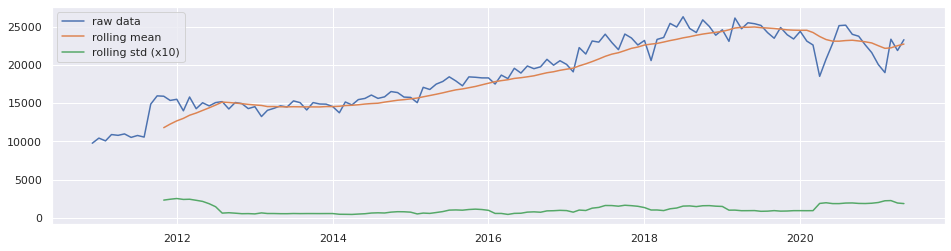

In [0]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(serious_crime_date['CrimeNumbers'],'raw data')

In [0]:
# Performing the Augmented Dickey-Fuller Test
def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

ADF_test(serious_crime_date['CrimeNumbers'],'raw data')

 > Is the raw data stationary ?
Test statistic = -0.934
P-value = 0.776
Critical values :
	1%: -3.4901313156261384 - The data is not stationary with 99% confidence
	5%: -2.8877122815688776 - The data is not stationary with 95% confidence
	10%: -2.5807296460459184 - The data is not stationary with 90% confidence


<Figure size 432x288 with 0 Axes>

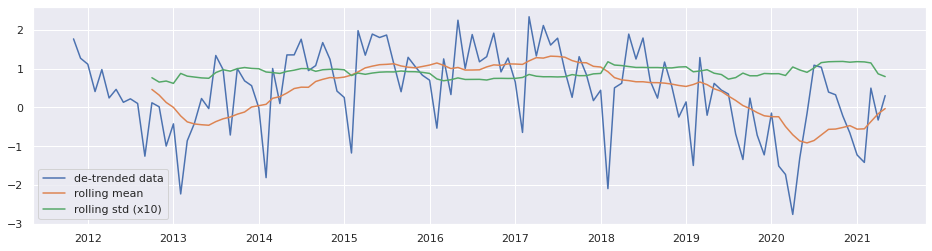

 > Is the de-trended data stationary ?
Test statistic = -1.642
P-value = 0.461
Critical values :
	1%: -3.4961490537199116 - The data is not stationary with 99% confidence
	5%: -2.8903209639580556 - The data is not stationary with 95% confidence
	10%: -2.5821223452518263 - The data is not stationary with 90% confidence


In [0]:
# Detrending
y = serious_crime_date['CrimeNumbers']
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

<Figure size 432x288 with 0 Axes>

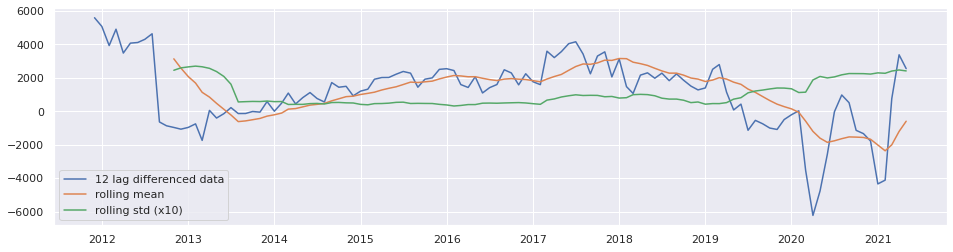

 > Is the 12 lag differenced data stationary ?
Test statistic = -1.678
P-value = 0.443
Critical values :
	1%: -3.4968181663902103 - The data is not stationary with 99% confidence
	5%: -2.8906107514600103 - The data is not stationary with 95% confidence
	10%: -2.5822770483285953 - The data is not stationary with 90% confidence


In [0]:
# Differencing
y_12lag =  y - y.shift(12)

test_stationarity(y_12lag,'12 lag differenced data')
ADF_test(y_12lag,'12 lag differenced data')

<Figure size 432x288 with 0 Axes>

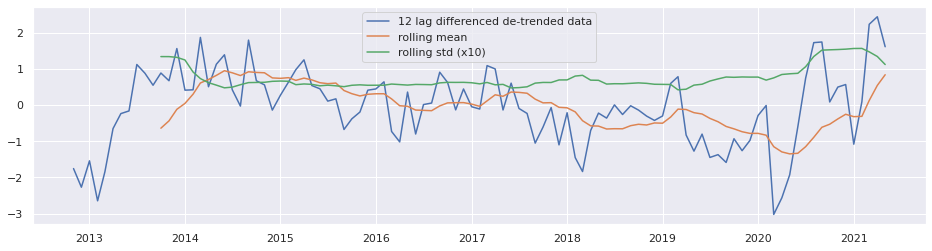

 > Is the 12 lag differenced de-trended data stationary ?
Test statistic = -2.584
P-value = 0.096
Critical values :
	1%: -3.505190196159122 - The data is not stationary with 99% confidence
	5%: -2.894232085048011 - The data is not stationary with 95% confidence
	10%: -2.5842101234567902 - The data is  stationary with 90% confidence


In [0]:
# Detrending + Differencing
y_12lag_detrend =  y_detrend - y_detrend.shift(12)

test_stationarity(y_12lag_detrend,'12 lag differenced de-trended data')

ADF_test(y_12lag_detrend,'12 lag differenced de-trended data')

In [0]:
# Removing Null from the detrended differenced data
y2 = y_12lag_detrend.dropna()
y2.head()

# Splitting data for training and testing
y_to_train = y2[:'2020-03-31'] # dataset to train
y_to_test = y2['2020-04-01': ] # dataset to test

In [0]:
warnings.filterwarnings("ignore") # Specifying to ignore warning messages

# Setting up parameter grids for Seasonal ARIMA
p = d = q = range(0, 2)
seasonal_period = 12
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
# Implementing a grid search for the optimal parameters for a Seasonal ARIMA (SARIMA)
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod =\
            sm.tsa.statespace.SARIMAX(y_to_train,
                                      order=param,
                                      seasonal_order=param_seasonal,
                                      enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except Exception as ex:
            print(ex)
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:247.92371612022856
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:243.79224813500505
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:272.8634817776387
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:248.32504204756188
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:243.28226224750534
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:244.9847377461568
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:244.26235703696977
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:243.71473102052585
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:218.4028029614687
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:209.5344556048242
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:255.08029031200982
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:223.83872901321715
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:209.64480599099957
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:211.6359273303581
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:220.12369066469907
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:217.35729095264247
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:208.73483627782423
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:185.949374183763

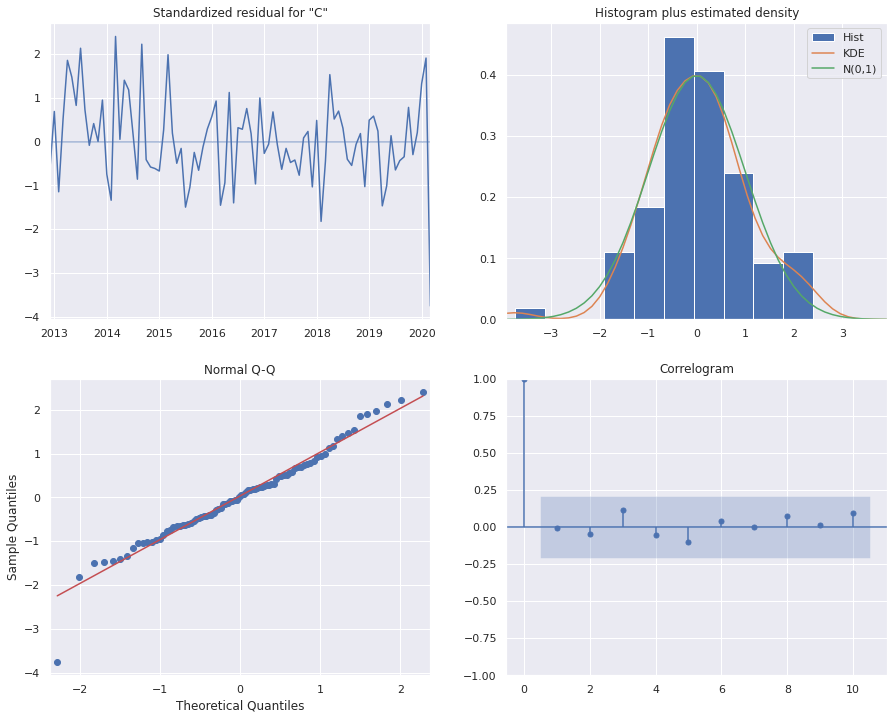

In [0]:
# Using Values from the previous step
order = (0, 1, 1)
seasonal_order = (1, 0, 0, 12)
model = sm.tsa.statespace.SARIMAX(y_to_train,
                            order=order,
                            seasonal_order=seasonal_order,
                            enforce_invertibility=False)
results = model.fit()

# Plotting
results.plot_diagnostics(figsize=(15, 12))
plt.show()

2020-04-01   -0.97862629
2020-05-01   -0.73137818
2020-06-01   -0.99226390
2020-07-01   -0.63449043
2020-08-01   -0.67739189
2020-09-01   -0.55789956
2020-10-01   -0.92158488
2020-11-01   -0.73813700
2020-12-01   -0.89570709
2021-01-01   -1.27762191
2021-02-01   -1.43085396
2021-03-01    0.23912144
Freq: MS, Name: predicted_mean, dtype: float64


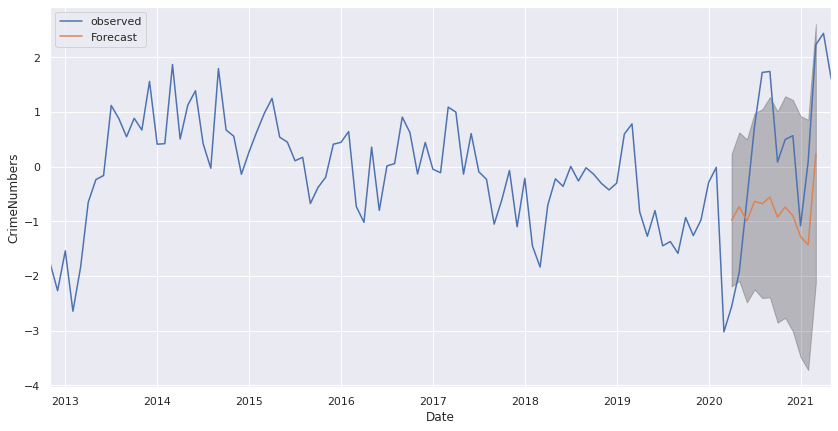

In [0]:
# Predicting
pred_uc = results.get_forecast(steps=12)
pred_ci = pred_uc.conf_int()

ax = y2.plot(label='observed', figsize=(14, 7))
print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel(y2.name)

plt.legend()
plt.show()